<a href="https://colab.research.google.com/github/Amarmurun0212/Diver/blob/main/Decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import enum
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import collections
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.colors



#problem 1-4
class ScratchDecesionTreeClassifierDepth1():
    """
    Scratch implementation of a decision tree classifier of depth 1

    Parameters
    ----------
    verbose : bool
      True if you want to output the learning progress
    """

    def __init__(self, verbose=False):
        # Record hyperparameters as attributes
        self.verbose = verbose

    def fit(self, X, y):
        """
        Learn the decision tree classifier

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
           Features of training data
        y : ndarray, shape (n_samples,) of the following form
            Label value of training data
        """

        self.gain = 0
        for feature_index in range(X.shape[1]):
            self.thresholds = np.unique(X[:,feature_index])
            for threshold in self.thresholds:
                _gain = self._calc_ig(X, feature_index, y, threshold)
                if _gain > self.gain:
                    self.l_label = collections.Counter(y[X[:,feature_index] < threshold]).most_common()[0][0]
                    self.r_label = collections.Counter(y[X[:,feature_index] >= threshold]).most_common()[0][0]
                    self.feature = feature_index
                    self.threshold = threshold
                    self.gain = _gain
                    if self.verbose:
                        print('feature',self.feature,'threshold',self.threshold,'gain',self.gain)

    def predict(self, X):
        """
        Estimate the label using a decision tree classifier
        """
        prediction = np.where(X[:,self.feature] < self.threshold,self.l_label,self.r_label)
        return prediction
    
    def _calc_gini(self,y):
        """
        Calculate Gini Impurity

        Parameters
        --------------
        y : ndarray, shape (n_samples,) of the following form
            Label value of training data
        """
        labels, counts = np.unique(y, return_counts=True)
        _gini = 0
        for label in labels:
            _gini += (counts[labels==label]/np.sum(counts))**2
        gini = 1 - _gini
        return gini
    
    def _calc_ig(self,X,feature_index,y,threshold):
        """
        Calculate Information gain

        Parameters
        --------------
        X : nd array, shape (n_samples, feature_size) of the following form
            feature values of training data
        feature_index : int
            feature number
        y : nd array, shape (n_samples,) of the following form
            Label value of training data
        threshold : int
            threshold value
        """

        labels_l = y[X[:,feature_index] < threshold]
        labels_r = y[X[:,feature_index] >= threshold]
        gain_l = (len(labels_l)/(len(labels_l)+len(labels_r)))*self._calc_gini(labels_l)
        gain_r = (len(labels_r)/(len(labels_l)+len(labels_r)))*self._calc_gini(labels_r)
        gain = self._calc_gini(y) -gain_l -gain_r
        return gain

In [18]:
class Node():
    """
    A class that composes and separates the nodes of a decision tree.

    Parameters:
    ---------------
    verbose : bool
        True if you want to output the learning progress
    max_depth = int
        Maximum training depth of decision tree
    """
    def __init__(self, max_depth = None, verbose = False):
        # Record hyperparameters as attributes
        self.verbose = verbose
        self.max_depth = max_depth
        self.feature = None

    def _separate(self, X, y, depth):
        """
        Split nodes using the CART method.
        Parameters:
        ---------------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : ndarray, shape (n_samples,) of the following form
            Label value of training data
        depth : int
            the depth of node
        """
        self.depth = depth
        features = X.shape[1]

        if len(np.unique(y))  == 1:
            self.label = np.unique(y)[0]
            return
        
        if self.depth == self.max_depth:
            self.label = statistics.mode(y)
            return
        
        self.gain = 0

        for feature_number in range(features):
            thresholds = np.unique(X[:,feature_number])
            for threshold_value in thresholds[1:]:
                labels_l = y[X[:,feature_number] < threshold_value]
                labels_r = y[X[:,feature_number] >= threshold_value]

                gain_l = (len(labels_l)/(len(labels_l)+len(labels_r)))*self._calc_gini(labels_l)
                gain_r = (len(labels_r)/(len(labels_l)+len(labels_r)))*self._calc_gini(labels_r)
                gain = self._calc_gini(y) -gain_l -gain_r

                if gain > self.gain:
                    self.feature = feature_number
                    self.threshold = threshold_value
                    self.gain = gain

        if self.verbose:
            print("depth", self.depth, 'feature',self.feature,'threshold',self.threshold,'gain',self.gain)
        
        l_X = X[X[:,self.feature] < self.threshold]
        l_y = y[X[:,self.feature] < self.threshold]
        self.left = Node(self.max_depth, self.verbose)
        self.left._separate(l_X, l_y, depth + 1)


        r_X = X[X[:,self.feature] >= self.threshold]
        r_y = y[X[:,self.feature] >= self.threshold]
        self.right = Node(self.max_depth, self.verbose)
        self.right._separate(r_X, r_y, depth + 1)
    
    def _calc_gini(self, y):
        """
        Calculate Gini Impurity

        Parameters
        --------------
        X : ndarray, shape (n_samples,) of the following form
            Features of training data
        """
        labels, counts = np.unique(y, return_counts=True)
        _gini = 0
        for label in labels:
            _gini += (counts[labels==label]/np.sum(counts))**2
        gini = 1 - _gini
        return gini
    
    def _predict(self, X):
        """
        Estimate label
        """
        if self.feature == None or self.depth == self.max_depth:
            return self.label
        else:
            if X[self.feature] < self.threshold:
                return self.left._predict(X)
            else:
                return self.right._predict(X)

In [19]:
class ScratchDecisionTreeClassifier():
    '''
    Scratch implementation of a decision tree classifier of depth n

    Parameters:
    ---------------
    verbose : bool
        True if you want to output the learning progress
    max_depth = int
        Maximum training depth of decision tree
    '''

    def __init__(self, max_depth = 1, verbose = False):
        # Record hyperparameters as attributes
        self.verbose = verbose
        self.max_depth = max_depth
    
    def fit(self, X, y):
        """
        Learn the decision tree classifier
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : ndarray, shape (n_samples, )
            Label values of training data
        """

        self.depth = 0
        self.root = Node(self.max_depth, self.verbose)
        self.root._separate(X, y, self.depth)

    def predict(self, X):
        """"
        Estimate labels using a decision tree classifier
        """
        y_pred = np.zeros(len(X))
        
        for i, x in enumerate(X):
            y_pred[i] = self.root._predict(x)
        return y_pred

In [23]:
def decision_region(X,y,slr):
    mesh_f0, mesh_f1  = np.meshgrid(
        np.arange(np.min(X[:,0]), np.max(X[:,0]), 0.01), 
        np.arange(np.min(X[:,1]), np.max(X[:,1]), 0.01)
    )
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    print("mesh shape:{}".format(mesh.shape))
    y_pred = slr.predict(mesh).reshape(mesh_f0.shape)
    plt.title('decision region')
    plt.xlabel('feature0')
    plt.ylabel('feature1')
    plt.contourf(mesh_f0, mesh_f1, y_pred,cmap=matplotlib.colors.ListedColormap(['pink', 'skyblue']))
    plt.contour(mesh_f0, mesh_f1, y_pred,colors='red')
    plt.scatter(X[y==0][:, 0], X[y==0][:, 1],label='0')
    plt.scatter(X[y==1][:, 0], X[y==1][:, 1],label='1')
    plt.legend()
    plt.show()

In [28]:
#Pro5 Learning and Estimation
iris = load_iris()
X = iris.data[:100,:]
y = iris.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=0)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

clf = ScratchDecesionTreeClassifierDepth1(verbose = True)
clf.fit(X_train,y_train)

prediction = clf.predict(X_test)

acc = accuracy_score(y_test, prediction)
precision = precision_score(y_test, prediction, average='micro')
recall = recall_score(y_test, prediction, average='micro')

print('Scratch Desicion tree: Accuracy', acc, 'Precision ', precision, 'Recall ',recall)

dtc = DecisionTreeClassifier(max_depth=1)
dtc.fit(X_train, y_train)

pred = dtc.predict(X_test)
acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='micro')
recall = recall_score(y_test, pred, average='micro')

print('Depth = 1 Sklearn Desicion tree: Accuracy', acc, 'Precision ', precision, 'Recall ',recall)

feature 0 threshold -1.5975414578074663 gain [0.01282051]
feature 0 threshold -1.435765107649749 gain [0.01948052]
feature 0 threshold -1.2739887574920306 gain [0.04054054]
feature 0 threshold -1.1122124073343136 gain [0.04794521]
feature 0 threshold -0.950436057176595 gain [0.07142857]
feature 0 threshold -0.7886597070188778 gain [0.08666667]
feature 0 threshold -0.6268833568611607 gain [0.12695925]
feature 0 threshold -0.4651070067034421 gain [0.20572745]
feature 0 threshold -0.303330656545725 gain [0.23142857]
feature 0 threshold -0.14155430638800642 gain [0.24747475]
feature 0 threshold 0.02022204376971069 gain [0.30050031]
feature 2 threshold -0.8121921245041062 gain [0.38888889]
feature 2 threshold -0.672610234148943 gain [0.47560976]
feature 2 threshold 0.0950901628044546 gain [0.5]
Scratch Desicion tree: Accuracy 1.0 Precision  1.0 Recall  1.0
Depth = 1 Sklearn Desicion tree: Accuracy 1.0 Precision  1.0 Recall  1.0


PRO6. Visualization of decision area

feature 0 threshold -1.6399145414216896 gain [0.00571203]
feature 0 threshold -1.489636003834365 gain [0.01758117]
feature 0 threshold -1.3393574662470402 gain [0.02375]
feature 0 threshold -1.1890789286597143 gain [0.05013889]
feature 0 threshold -1.0388003910723898 gain [0.06446429]
feature 0 threshold -0.8885218534850636 gain [0.0957197]
feature 0 threshold -0.738243315897739 gain [0.12176587]
feature 0 threshold -0.5879647783104144 gain [0.14184091]
feature 0 threshold -0.4376862407230883 gain [0.20716393]
feature 0 threshold -0.28740770313576364 gain [0.23573413]
feature 0 threshold -0.13712916554843765 gain [0.25102273]
feature 0 threshold 0.013149372038887004 gain [0.33949422]
mesh shape:(174858, 2)


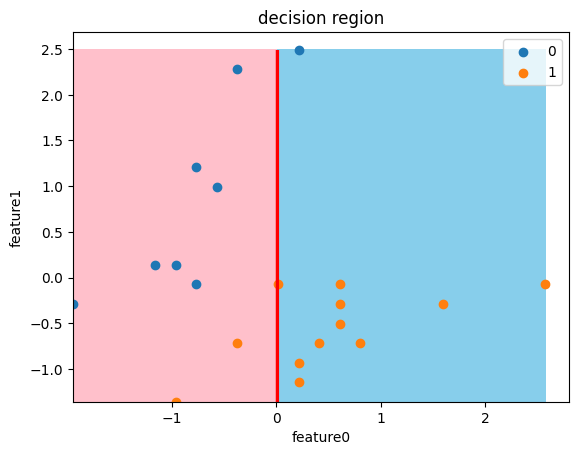

In [25]:
X = iris.data[:100,:2]
y = iris.target[:100]
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
clf = ScratchDecesionTreeClassifierDepth1(verbose = True)
clf.fit(X_train,y_train)
decision_region(X_test, y_test, clf)


(Advanced exercise) Creating a decision tree classifier class with depth 2

In [26]:
clf2 = ScratchDecisionTreeClassifier(max_depth= 2, verbose = True)
clf2.fit(X_train, y_train)

pred = clf2.predict(X_test)
print(pred)
print(y_test)
acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='micro')
recall = recall_score(y_test, pred, average='micro')
print('Depth = 2 Scratch Desicion tree: Accuracy ',acc, 'Precision ', precision,'Recall', recall)


depth 0 feature 0 threshold 0.013149372038887004 gain [0.33949422]
depth 1 feature 1 threshold -0.24095992131279825 gain [0.09904819]
depth 1 feature 1 threshold 0.8066919104819708 gain [0.18408941]
[1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1.]
[1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1]
Depth = 2 Scratch Desicion tree: Accuracy  0.95 Precision  0.95 Recall 0.95


(Advanced exercise) Creating a decision tree classifier class with unlimited depth

In [27]:
clf = ScratchDecisionTreeClassifier(max_depth= None, verbose = True)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)
print(pred)
print(y_test)
acc = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred, average='micro')
recall = recall_score(y_test, pred, average='micro')
print('Depth = None Scratch Desicion tree: Accuracy', acc, 'Precision ', precision, 'Recall ',recall)

depth 0 feature 0 threshold 0.013149372038887004 gain [0.33949422]
depth 1 feature 1 threshold -0.24095992131279825 gain [0.09904819]
depth 2 feature 0 threshold -0.738243315897739 gain [0.375]
depth 1 feature 1 threshold 0.8066919104819708 gain [0.18408941]
[1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.]
[1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1]
Depth = None Scratch Desicion tree: Accuracy 0.95 Precision  0.95 Recall  0.95
